In [8]:
import cv2
import numpy as np
import networkx as nx
from drawwithplt import plt

def find_intersections(image_path):
    # 读取图片
    img = cv2.imread(image_path, 0)
    
    # 使用Canny边缘检测
    edges = cv2.Canny(img, 50, 150)
    
    # 找到交叉点
    intersections = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    intersection_points = []
    if intersections is not None:
        for line in intersections:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            intersection_points.append((x0, y0))
            
    return intersection_points

def build_adjacency_matrix(intersections):
    # 假设在一定的距离范围内的交点是相连的，设置这个阈值
    distance_threshold = 50
    
    num_intersections = len(intersections)
    adjacency_matrix = np.zeros((num_intersections, num_intersections))
    
    for i in range(num_intersections):
        for j in range(num_intersections):
            dist = np.sqrt((intersections[i][0]-intersections[j][0])**2 + (intersections[i][1]-intersections[j][1])**2)
            if dist < distance_threshold and i != j:
                adjacency_matrix[i][j] = 1
    
    return adjacency_matrix


def draw_network(adjacency_matrix, position_dict):
    # 初始化图形
    fig, ax = plt.subplots()
    
    # 绘制每一个路口点
    for node, position in position_dict.items():
        ax.scatter(*position, s=100, color='red', label=f'Node {node}')
        # ax.text(position[0], position[1], str(node), fontsize=12, ha='center', va='center', color='white')

    # 根据邻接矩阵绘制连线
    num_nodes = len(position_dict)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i][j] == 1:
                ax.plot([position_dict[i][0], position_dict[j][0]], 
                        [position_dict[i][1], position_dict[j][1]], color='blue')
    
    # 显示图形
    plt.show()



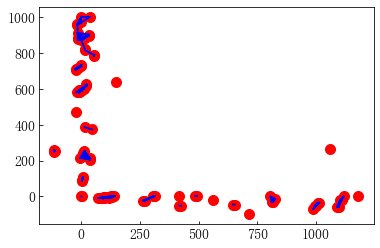

In [9]:

def main():
    intersections = find_intersections('Data/Edge-roadtest.png')
    
    adjacency_matrix = build_adjacency_matrix(intersections)
    
    position_dict = {i: intersections[i] for i in range(len(intersections))}
    
    # print(adjacency_matrix)
    # print(position_dict)

    draw_network(adjacency_matrix, position_dict)

main()

In [15]:
def detect_intersections_and_roads(image_path):
    # 读取图片
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 使用Canny边缘检测
    edges = cv2.Canny(gray, 50, 150)

    # 使用霍夫变换来检测直线
    lines = cv2.HoughLines(edges, 1, np.pi/180, 150)

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # 使用角点检测来识别路口
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.01, 10)
    corners = np.int0(corners)
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(img, (x, y), 3, 255, -1)

    return img

# 使用上述函数处理图像
result_img = detect_intersections_and_roads('Data/Edge-roadtest.png')
cv2.imshow('Detected Roads and Intersections', result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Intersections: {0: (0, 0), 1: (60, 0), 2: (61, 0), 3: (104, 0), 4: (123, 0), 5: (196, 0), 6: (343, 0), 7: (500, 0), 8: (516, 0), 9: (619, 0), 10: (709, 0), 11: (815, 0), 12: (879, 0), 13: (1044, 0), 14: (1061, 0), 15: (1108, 0), 16: (1139, 0), 17: (1179, 0), 18: (1183, 0), 19: (0, 5), 20: (1103, 14), 21: (113, 24), 22: (115, 24), 23: (1035, 43), 24: (1037, 43), 25: (1021, 45), 26: (815, 72), 27: (96, 79), 28: (80, 80), 29: (80, 81), 30: (81, 81), 31: (82, 81), 32: (79, 82), 33: (80, 82), 34: (81, 82), 35: (81, 83), 36: (82, 83), 37: (86, 83), 38: (1183, 112), 39: (0, 139), 40: (1183, 154), 41: (470, 215), 42: (469, 217), 43: (1183, 232), 44: (144, 243), 45: (1183, 251), 46: (0, 270), 47: (847, 286), 48: (1183, 295), 49: (185, 314), 50: (164, 315), 51: (183, 315), 52: (184, 315), 53: (0, 352), 54: (149, 352), 55: (1183, 363), 56: (1092, 389), 57: (1128, 394), 58: (1183, 425), 59: (1183, 445), 60: (1006, 449), 61: (992, 466), 62: (994, 466), 63: (994, 467), 64: (0, 481), 65: (1183, 515),

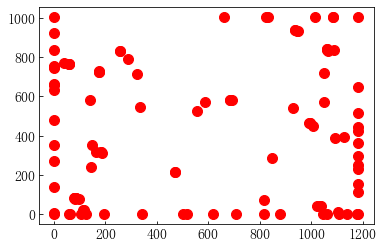

In [7]:
import cv2
import numpy as np

def extract_intersections(binary_img):
    # 使用骨架化操作
    skeleton = cv2.ximgproc.thinning(binary_img)

    # 使用交点检测来找到路口
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    anchor_points = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, kernel)
    y, x = np.where(anchor_points > 0)
    intersections = list(zip(x, y))
    
    # 使用字典代替列表
    return {i: coord for i, coord in enumerate(intersections)}

def create_adjacency_matrix(intersections, skeleton):
    num_intersections = len(intersections)
    adjacency_matrix = np.zeros((num_intersections, num_intersections))

    for i in range(num_intersections):
        for j in range(num_intersections):
            if i != j:
                # Check if a line between two intersections crosses the skeleton
                line_img = np.zeros_like(skeleton)
                cv2.line(line_img, intersections[i], intersections[j], 1, 1)
                if np.any(np.logical_and(line_img, skeleton)):
                    adjacency_matrix[i][j] = 1

    return adjacency_matrix

def draw_network(adjacency_matrix, position_dict):
    # 初始化图形
    fig, ax = plt.subplots()
    
    # 绘制每一个路口点
    for node, position in position_dict.items():
        ax.scatter(*position, s=100, color='red', label=f'Node {node}')
        # ax.text(position[0], position[1], str(node), fontsize=12, ha='center', va='center', color='white')

    # 根据邻接矩阵绘制连线
    num_nodes = len(position_dict)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i][j] == 1:
                # ax.plot([position_dict[i][0], position_dict[j][0]], 
                #         [position_dict[i][1], position_dict[j][1]], color='blue')
                pass
    # 显示图形
    plt.show()

img = cv2.imread("./Data/Edge-roadtest.png", cv2.IMREAD_GRAYSCALE)

# 通过颜色阈值进行二值化
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

intersections = extract_intersections(binary_img)
adjacency_matrix = create_adjacency_matrix(intersections, binary_img)

print("Intersections:", intersections)
print("Adjacency Matrix:\n", adjacency_matrix)

draw_network(adjacency_matrix, intersections)

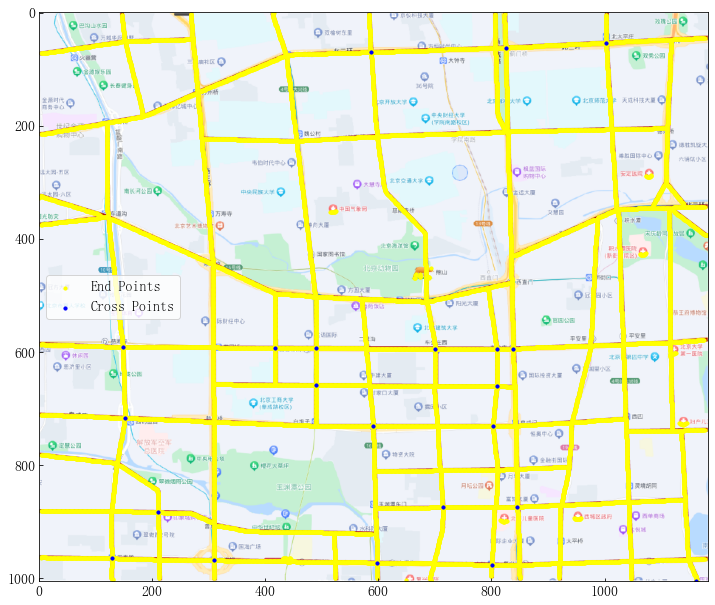

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载图像
img = cv2.imread("./Data/Edge-roadtest.png")

# 颜色过滤，提取深红色
lower_bound = np.array([0, 0, 100]) # 需要调整
upper_bound = np.array([100, 100, 255]) # 需要调整
mask = cv2.inRange(img, lower_bound, upper_bound)

# 骨架化
skeleton = cv2.ximgproc.thinning(mask)

# 对于粗线条，增大端点检测核的尺寸
kernel_end_thick = np.array([[0, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 0], 
                            [0, 0, 1, 0, 0], 
                            [2, 2, 2, 2, 2],
                            [2, 2, 2, 2, 2]], dtype=np.uint8)
end_points_thick = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, kernel_end_thick)

# 对于粗线条，增大交叉点检测核的尺寸
kernel_cross_thick = np.array([[2, 1, 1, 1, 2], 
                              [1, 1, 1, 1, 1], 
                              [1, 1, 1, 1, 1], 
                              [1, 1, 1, 1, 1],
                              [2, 1, 1, 1, 2]], dtype=np.uint8)
cross_points_thick = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, kernel_cross_thick)


# 结果显示
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ys, xs = np.where(end_points)
plt.scatter(xs, ys, color='yellow', s=10, label="End Points")
ys, xs = np.where(cross_points)
plt.scatter(xs, ys, color='blue', s=10, label="Cross Points")
plt.legend()
plt.show()


In [15]:
import cv2
import numpy as np

# 1. 识别蓝色的圆点并标记它们的坐标：
image = cv2.imread("./Data/Edge-roadtest.png")
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 蓝色的HSV范围
lower_blue = np.array([100, 50, 50])
upper_blue = np.array([140, 255, 255])

mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

blue_points = [(cv2.moments(contour)['m10']/cv2.moments(contour)['m00'], cv2.moments(contour)['m01']/cv2.moments(contour)['m00']) for contour in contours if cv2.moments(contour)['m00'] != 0]


# 2. 对每个蓝色圆点进行编号：
blue_points_sorted = sorted(blue_points, key=lambda x: (x[1], x[0]))

for i, point in enumerate(blue_points_sorted):
    cv2.putText(image, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# 3. 识别深红色的道路：
lower_red = np.array([0, 50, 50])
upper_red = np.array([10, 255, 255])
mask_red1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red = np.array([160, 50, 50])
upper_red = np.array([180, 255, 255])
mask_red2 = cv2.inRange(hsv, lower_red, upper_red)

mask_red = mask_red1 + mask_red2

# 4. 建立邻接矩阵：
adjacency_matrix = np.zeros((len(blue_points), len(blue_points)))

for i, point1 in enumerate(blue_points_sorted):
    for j, point2 in enumerate(blue_points_sorted):
        x1, y1 = int(point1[0]), int(point1[1])
        x2, y2 = int(point2[0]), int(point2[1])
        
        line_points = cv2.line(np.zeros_like(mask_red), (x1, y1), (x2, y2), 1, 2)
        intersect = np.logical_and(line_points, mask_red)
        
        if np.any(intersect):
            adjacency_matrix[i, j] = 1

print(adjacency_matrix)

cv2.imshow("Result Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]]


In [17]:
from PIL import Image
import numpy as np

# 读取图像并转换为数组
image = Image.open("./Data/Edge-roadtest.png")
data = np.array(image)

# 识别纯蓝色的像素
blue_points = np.where((data[:,:,0] == 0) & (data[:,:,1] == 0) & (data[:,:,2] == 255))
blue_coords = list(zip(blue_points[1], blue_points[0]))

# 识别深红色的像素
red_points = np.where((data[:,:,0] == 139) & (data[:,:,1] == 0) & (data[:,:,2] == 0))
red_coords = list(zip(red_points[1], red_points[0]))

# 构建邻接矩阵
adj_matrix = np.zeros((len(blue_coords), len(blue_coords)), dtype=int)
for i, start in enumerate(blue_coords):
    for j, end in enumerate(blue_coords):
        if i != j:
            # 检查两个交叉点之间是否存在深红色的像素连接
            if start[0] == end[0]:  # 同一列
                segment = data[start[1]:end[1], start[0], 0]
                if all(pixel == 139 for pixel in segment):
                    adj_matrix[i][j] = 1
            elif start[1] == end[1]:  # 同一行
                segment = data[start[1], start[0]:end[0], 0]
                if all(pixel == 139 for pixel in segment):
                    adj_matrix[i][j] = 1

blue_dict = {i: coord for i, coord in enumerate(blue_coords)}

print("交叉点坐标字典:", blue_dict)
print("邻接矩阵:")
print(adj_matrix)

交叉点坐标字典: {0: (269, 40), 1: (270, 40), 2: (271, 40), 3: (272, 40), 4: (273, 40), 5: (274, 40), 6: (275, 40), 7: (276, 40), 8: (1116, 40), 9: (1117, 40), 10: (1118, 40), 11: (1119, 40), 12: (1120, 40), 13: (268, 41), 14: (269, 41), 15: (270, 41), 16: (271, 41), 17: (272, 41), 18: (273, 41), 19: (274, 41), 20: (275, 41), 21: (276, 41), 22: (277, 41), 23: (1114, 41), 24: (1115, 41), 25: (1116, 41), 26: (1117, 41), 27: (1118, 41), 28: (1119, 41), 29: (1120, 41), 30: (1121, 41), 31: (1122, 41), 32: (267, 42), 33: (268, 42), 34: (269, 42), 35: (270, 42), 36: (271, 42), 37: (272, 42), 38: (273, 42), 39: (274, 42), 40: (275, 42), 41: (276, 42), 42: (277, 42), 43: (278, 42), 44: (1113, 42), 45: (1114, 42), 46: (1115, 42), 47: (1116, 42), 48: (1117, 42), 49: (1118, 42), 50: (1119, 42), 51: (1120, 42), 52: (1121, 42), 53: (1122, 42), 54: (1123, 42), 55: (266, 43), 56: (267, 43), 57: (268, 43), 58: (269, 43), 59: (270, 43), 60: (271, 43), 61: (272, 43), 62: (273, 43), 63: (274, 43), 64: (275, 43), 

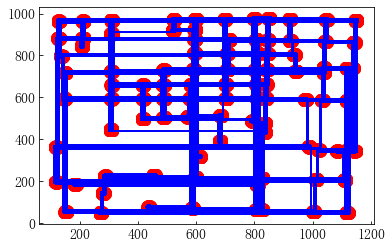

In [18]:
draw_network(adj_matrix, blue_dict)